<a href="https://colab.research.google.com/github/icarovazquez/Lanista/blob/master/EPL_Match_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook takes the [English Premiership results dataset on Kaggle](https://www.kaggle.com/irkaal/english-premier-league-results) and creates a neural network that tries to predict English premiership match results


First we import pandas and mount google drive so we can choose which file we are going to use

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import codecs, json
import tempfile
import requests
import base64


from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


just to be sure the drive is mounted we can do an ls command to see the drive contents

In [2]:
!ls

drive  sample_data  server.log


Our file is under /content/drive/My Drive/file_name. In this case we are going to use a [Kaggle public dataset](https://www.kaggle.com/irkaal/english-premier-league-results) (Thanks Alvin!) that has all the English Premiership matches from the 2000-2001 season to the 2019-2020 season. 

We are going to load this file into a panda dataframe and we will take a look at the first few rows of the file to see the content



In [3]:
file_path = "/content/drive/My Drive/EPLresults.csv"
my_df = pd.read_csv(file_path)

print(my_df.shape)
print(my_df.info())

my_df.head()



(7386, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7386 entries, 0 to 7385
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      7386 non-null   object
 1   HomeTeam  7386 non-null   object
 2   AwayTeam  7386 non-null   object
 3   FTHG      7386 non-null   int64 
 4   FTAG      7386 non-null   int64 
 5   FTR       7386 non-null   object
 6   HTHG      7386 non-null   int64 
 7   HTAG      7386 non-null   int64 
 8   HTR       7386 non-null   object
 9   Referee   7386 non-null   object
 10  HS        7386 non-null   int64 
 11  AS        7386 non-null   int64 
 12  HST       7386 non-null   int64 
 13  AST       7386 non-null   int64 
 14  HC        7386 non-null   int64 
 15  AC        7386 non-null   int64 
 16  HF        7386 non-null   int64 
 17  AF        7386 non-null   int64 
 18  HY        7386 non-null   int64 
 19  AY        7386 non-null   int64 
 20  HR        7386 non-null   int64 
 21  AR 

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
0,19/08/00,Charlton,Man City,4,0,H,2,0,H,Rob Harris,17,8,14,4,6,6,13,12,1,2,0,0
1,19/08/00,Chelsea,West Ham,4,2,H,1,0,H,Graham Barber,17,12,10,5,7,7,19,14,1,2,0,0
2,19/08/00,Coventry,Middlesbrough,1,3,A,1,1,D,Barry Knight,6,16,3,9,8,4,15,21,5,3,1,0
3,19/08/00,Derby,Southampton,2,2,D,1,2,A,Andy D'Urso,6,13,4,6,5,8,11,13,1,1,0,0
4,19/08/00,Leeds,Everton,2,0,H,2,0,H,Dermot Gallagher,17,12,8,6,6,4,21,20,1,3,0,0


Now let's plot the data to see how the features are correlated

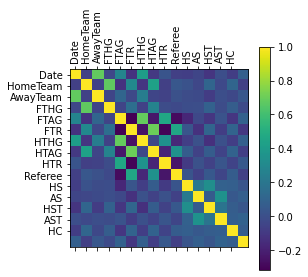

In [4]:
plt.matshow(my_df.corr())
plt.xticks( np.arange(15), my_df.columns, rotation=90)
plt.yticks( np.arange(15), my_df.columns, rotation=0)
plt.colorbar()
plt.show()

Now that the file is in dataframe we assign some columns to x and the label to y. In our case the label is the full time result ("FTR"). Let's make sure we can print a label

In [5]:
print("For row 149 the teams playing are " + str(my_df["HomeTeam"][149]) + " and " + str(my_df["AwayTeam"][149]) + " and the label is "  + str(my_df["FTR"][149]) + " and the day is " + str(my_df["Date"][149]))

For row 149 the teams playing are Arsenal and Southampton and the label is H and the day is 02/12/00



Before assigning the features to x an Y we need to convert strings and text to something else since you cannot input strings to a neural network 

What features to use? Well, a theory is we need the teams that are playing and their statistics throughout the match: assists, corners and so on. Date? For now we are going to use just the day ofthe week so we will start with the following features in x:

*   Day of the week when the match was played (i.e Saturday)  
*   HomeTeam
*   AwayTeam
*   HTHG (Half Time Home Goals)
*   HTAG (Half Time Away Goals)
*   HTR  (Half Time Result)
*   HS (Home Team Shots)
*   AS (Away Team Shots)
*  HC (Home Team Corners)
*  AC (Away Team Corners)
*  HF (Home Team Fouls)
*  AF (Away Team Fouls)
*  HY (Homw Team Yellow Cards)
*  AY (Away Team Yellow Cards)
*   HR (Home Team Red Cards)
*   AR (Away Team Red Cards)

Now we need to convert the object columns to numbers. First we create a new dataframe with the object columns. 

We also drop the referee column since we are not going to use it and then we print a few rows

In [6]:
epl_df_objects = my_df.copy()
epl_df_objects.drop('Referee', axis=1, inplace=True)


epl_df_objects.head()



,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
0,19/08/00,Charlton,Man City,4,0,H,2,0,H,17,8,14,4,6,6,13,12,1,2,0,0
1,19/08/00,Chelsea,West Ham,4,2,H,1,0,H,17,12,10,5,7,7,19,14,1,2,0,0
2,19/08/00,Coventry,Middlesbrough,1,3,A,1,1,D,6,16,3,9,8,4,15,21,5,3,1,0
3,19/08/00,Derby,Southampton,2,2,D,1,2,A,6,13,4,6,5,8,11,13,1,1,0,0
4,19/08/00,Leeds,Everton,2,0,H,2,0,H,17,12,8,6,6,4,21,20,1,3,0,0


Now we are going to check if there are any null values


In [7]:
print(epl_df_objects.isnull().values.sum())


0


Hooray! No null values so we don't have to fix our data. We can move on to the next step: fixing some of the features we want to keep.

Since we only want the day the match was played we convert the date to day of the week in a new column and drop the original date column 

In [8]:
#converting match date to epoch and day of the week

epl_df_objects["matchDate"] = pd.to_datetime(epl_df_objects["Date"], infer_datetime_format=True)
epl_df_objects['matchDay'] = epl_df_objects['matchDate'].dt.day_name()

print(epl_df_objects["matchDate"][0])
print(epl_df_objects['matchDay'][149])

epl_df_objects.drop('Date', axis=1, inplace=True)
epl_df_objects.drop('matchDate', axis=1, inplace=True)


epl_df_objects.head()

2000-08-19 00:00:00
Saturday


,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,matchDay
0,Charlton,Man City,4,0,H,2,0,H,17,8,14,4,6,6,13,12,1,2,0,0,Saturday
1,Chelsea,West Ham,4,2,H,1,0,H,17,12,10,5,7,7,19,14,1,2,0,0,Saturday
2,Coventry,Middlesbrough,1,3,A,1,1,D,6,16,3,9,8,4,15,21,5,3,1,0,Saturday
3,Derby,Southampton,2,2,D,1,2,A,6,13,4,6,5,8,11,13,1,1,0,0,Saturday
4,Leeds,Everton,2,0,H,2,0,H,17,12,8,6,6,4,21,20,1,3,0,0,Saturday


Now we convert all the object columns to numbers because a neural network does not accept text

In [9]:
epl_df_objects = pd.get_dummies(epl_df_objects, columns=['HomeTeam'], prefix = ['HomeTeam'])
epl_df_objects = pd.get_dummies(epl_df_objects, columns=['AwayTeam'], prefix = ['AwayTeam'])
epl_df_objects = pd.get_dummies(epl_df_objects, columns=['HTR'], prefix = ['HTR'])
epl_df_objects = pd.get_dummies(epl_df_objects, columns=['matchDay'], prefix = ['matchDay'])

epl_df_objects.head()



,FTHG,FTAG,FTR,HTHG,HTAG,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HomeTeam_Arsenal,HomeTeam_Aston Villa,HomeTeam_Birmingham,HomeTeam_Blackburn,HomeTeam_Blackpool,HomeTeam_Bolton,HomeTeam_Bournemouth,HomeTeam_Bradford,HomeTeam_Brighton,HomeTeam_Burnley,HomeTeam_Cardiff,HomeTeam_Charlton,HomeTeam_Chelsea,HomeTeam_Coventry,HomeTeam_Crystal Palace,HomeTeam_Derby,HomeTeam_Everton,HomeTeam_Fulham,HomeTeam_Huddersfield,HomeTeam_Hull,HomeTeam_Ipswich,HomeTeam_Leeds,HomeTeam_Leicester,...,AwayTeam_Coventry,AwayTeam_Crystal Palace,AwayTeam_Derby,AwayTeam_Everton,AwayTeam_Fulham,AwayTeam_Huddersfield,AwayTeam_Hull,AwayTeam_Ipswich,AwayTeam_Leeds,AwayTeam_Leicester,AwayTeam_Liverpool,AwayTeam_Man City,AwayTeam_Man United,AwayTeam_Middlesbrough,AwayTeam_Newcastle,AwayTeam_Norwich,AwayTeam_Portsmouth,AwayTeam_QPR,AwayTeam_Reading,AwayTeam_Sheffield United,AwayTeam_Southampton,AwayTeam_Stoke,AwayTeam_Sunderland,AwayTeam_Swansea,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves,HTR_A,HTR_D,HTR_H,matchDay_Friday,matchDay_Monday,matchDay_Saturday,matchDay_Sunday,matchDay_Thursday,matchDay_Tuesday,matchDay_Wednesday
0,4,0,H,2,0,17,8,14,4,6,6,13,12,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,4,2,H,1,0,17,12,10,5,7,7,19,14,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
2,1,3,A,1,1,6,16,3,9,8,4,15,21,5,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,2,2,D,1,2,6,13,4,6,5,8,11,13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,2,0,H,2,0,17,12,8,6,6,4,21,20,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


Before assigning features to X and the label to y we need to convert the label to numeric values. We alsos assign all the relevant features to an intermediate variable

In [10]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()


epl_df_objects['FTR']= label_encoder.fit_transform(epl_df_objects['FTR']) 
  
print('Unique values for our label are: ', epl_df_objects['FTR'].unique())
print('if the home team wins the label is ', epl_df_objects['FTR'][0])
print('if the away team wins the label is ', epl_df_objects['FTR'][2])
print('if there is a tie the label is ', epl_df_objects['FTR'][3])

label = epl_df_objects['FTR']
print(label[149])

print(epl_df_objects.iloc[:,3:113])

features = epl_df_objects.iloc[:,3:113]

#for col in epl_df_objects.columns: 
#   print(col) 

Unique values for our label are:  [2 0 1]
if the home team wins the label is  2
if the away team wins the label is  0
if there is a tie the label is  1
2
      HTHG  HTAG  HS  ...  matchDay_Thursday  matchDay_Tuesday  matchDay_Wednesday
0        2     0  17  ...                  0                 0                   0
1        1     0  17  ...                  0                 0                   0
2        1     1   6  ...                  0                 0                   0
3        1     2   6  ...                  0                 0                   0
4        2     0  17  ...                  0                 0                   0
...    ...   ...  ..  ...                ...               ...                 ...
7381     0     0  11  ...                  0                 0                   0
7382     1     0  21  ...                  0                 0                   0
7383     2     0  17  ...                  0                 0                   0
7384     1     0

Now we can create X and y and divide the dataset in a training set and a test set. We will use the test set to check and see if we are overfitting

In [11]:
from sklearn.model_selection import train_test_split

y=np.ravel(label)
X = features


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

print("The shape of X_train is " + str(X_train.shape))
print("The size of y_train is " + str(y_train.shape))
print("The size of X_test set is " + str(X_test.shape))
print("The size of y_test is " + str(y_test.shape))

print(X_train)
print(y_train[0])

The shape of X_train is (4948, 110)
The size of y_train is (4948,)
The size of X_test set is (2438, 110)
The size of y_test is (2438,)
      HTHG  HTAG  HS  ...  matchDay_Thursday  matchDay_Tuesday  matchDay_Wednesday
0        2     0  17  ...                  0                 0                   0
1        1     0  17  ...                  0                 0                   0
2        1     1   6  ...                  0                 0                   0
3        1     2   6  ...                  0                 0                   0
4        2     0  17  ...                  0                 0                   0
...    ...   ...  ..  ...                ...               ...                 ...
4943     0     0  23  ...                  0                 0                   0
4944     0     1  16  ...                  0                 0                   0
4945     1     1  12  ...                  0                 0                   0
4946     1     0  22  ...          

Great!

Let's print a few rows of y_train to make sure they are one hot-encoded

In [12]:
#one hot-encoding y_train and y_test
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

print("The size of y_train is " + str(y_train.shape))
print("The size of y_test is " + str(y_test.shape))

print(y_train[0])

The size of y_train is (4948, 3)
The size of y_test is (2438, 3)
[0. 0. 1.]


We now create our models. We will start with a neural network using tensorflow and keras

In [13]:
model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(330, input_dim=110, activation='relu'), 
      tf.keras.layers.Dense(10, input_dim=330, activation='relu'),                               
      tf.keras.layers.Dense(3,activation='softmax')
])

model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 330)               36630     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3310      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 39,973
Trainable params: 39,973
Non-trainable params: 0
_________________________________________________________________


Our model is now ready to be fitted. 

In [14]:
history = model.fit(X_train, y_train, epochs=65)


Epoch 1/65
155/155 [==============================] - 0s 2ms/step - loss: 0.8804 - accuracy: 0.5914
Epoch 2/65
155/155 [==============================] - 0s 2ms/step - loss: 0.7976 - accuracy: 0.6427
Epoch 3/65
155/155 [==============================] - 0s 2ms/step - loss: 0.7551 - accuracy: 0.6542
Epoch 4/65
155/155 [==============================] - 0s 2ms/step - loss: 0.7490 - accuracy: 0.6629
Epoch 5/65
155/155 [==============================] - 0s 2ms/step - loss: 0.7388 - accuracy: 0.6633
Epoch 6/65
155/155 [==============================] - 0s 2ms/step - loss: 0.7264 - accuracy: 0.6758
Epoch 7/65
155/155 [==============================] - 0s 2ms/step - loss: 0.7237 - accuracy: 0.6698
Epoch 8/65
155/155 [==============================] - 0s 2ms/step - loss: 0.7135 - accuracy: 0.6758
Epoch 9/65
155/155 [==============================] - 0s 2ms/step - loss: 0.7067 - accuracy: 0.6833
Epoch 10/65
155/155 [==============================] - 0s 2ms/step - loss: 0.7021 - accuracy: 0.6910

Now we can evaluate our model on the test set

In [15]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

77/77 [==============================] - 0s 1ms/step - loss: 2.8141 - accuracy: 0.5751
Test Score: 2.81408429145813
Test Accuracy: 0.5750615000724792


Now let's try to make a prediction with data from a future premiership match from this current season:

Arsenal at home vs Norwich on Wednesday 07/01/2020



In [16]:
Xnew = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
print(Xnew.shape)

 # make a prediction
ynew = np.argmax(model.predict(Xnew), axis=-1)
# show the inputs and predicted outputs
print("X = %s " % Xnew)
print("Prediction = %s" % ynew[0])

if ynew[0] == 2:
  print("Home team is going to win")
elif ynew[0] == 0:
  print("Away team is going to win")
else:
  print("It is going to be a draw")

(1, 110)
X = [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1]] 
Prediction = 2
Home team is going to win


Now let's try to serve the model as an api so people can call it and get predictions for their games they want to know about.

We will use tensorflow serving to create our api

First we save our model


In [17]:
MODEL_DIR = tempfile.gettempdir()

version = 1

export_path = os.path.join(MODEL_DIR, str(version))

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

model.save(export_path, save_format="tf")

print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}


Already saved a model, cleaning up

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/1/assets

export_path = /tmp/1
total 96
drwxr-xr-x 2 root root  4096 Jun 29 06:59 assets
-rw-r--r-- 1 root root 89355 Jun 29 06:59 saved_model.pb
drwxr-xr-x 2 root root  4096 Jun 29 06:59 variables


In [18]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  25370      0 --:--:-- --:--:-- --:--:-- 25370
OK
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:2 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bi

Now we install tensorflow model server

In [19]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tensorflow-model-server is already the newest version (2.2.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 68 not upgraded.


Now we can run our api server. 

In [20]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [21]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=epl_predictions \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


Now we can create the a json object to send a request to the api

In [22]:
entry = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

print(type(entry))
print(entry.shape)

the_list = entry.tolist()
print(type(the_list))


data = json.dumps({"signature_name": "serving_default", "instances": the_list})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

<class 'numpy.ndarray'>
(1, 110)
<class 'list'>
Data: {"signature_name": "serving_default", "instances": ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]}


Now that we have our object we can send it to the api and we can receive the prediction from our model

In [23]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/epl_predictions:predict', data=data, headers=headers)

print(json_response)
print(json_response.text)

#predictions = json.loads(json_response.text)['predictions']

<Response [200]>
{
    "predictions": [[7.00302689e-06, 0.0823666081, 0.917626381]
    ]
}


And that's it! the API returns 3 predictions with the last one being the most probable. The last one is 2 so our model is predicting the home team is going to win!